In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv(r'/Users/admin/desktop/loanDefaults/Loan_default.csv', index_col=0)

In [4]:
pd.set_option('display.max_rows', 10)

In [5]:
print(df.isna().sum())

Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
                 ..
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
Length: 17, dtype: int64


In [6]:
#no empty values detected

In [7]:
#Encoding values 

In [8]:
label_encoder = LabelEncoder()

In [9]:
columns_to_encode = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']
df[columns_to_encode] = df[columns_to_encode].apply(lambda col: label_encoder.fit_transform(col))

In [10]:
#Train, validation, test split

In [11]:
train,valid,test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [13]:
def scale_dataset(df):
    x = df[df.columns[:-1]].values
    y = df[df.columns[-1]].values
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    data = np.hstack((x, np.reshape(y, (-1,1))))
    return data, x, y

In [14]:
train, x_train, y_train = scale_dataset(df)
valid, x_valid, y_valid = scale_dataset(df)
test, x_test, y_test = scale_dataset(df)

In [15]:
train_df = pd.DataFrame(train, columns=df.columns)

In [16]:
pre_x_1 = len(train_df[train_df['Default']==0])
pre_x_2 = len(train_df[train_df['Default']==1])

In [17]:
print(pre_x_1, pre_x_2)

225694 29653


In [18]:
# Since classes are imbalanced, the oversampler is addede to the function 

In [19]:
def scale_dataset(df, oversampler=False):
    x = df[df.columns[:-1]].values
    y = df[df.columns[-1]].values
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    if oversampler:
        ros = RandomOverSampler()
        x,y = ros.fit_resample(x,y)
    data = np.hstack((x, np.reshape(y, (-1,1))))
    return data, x, y

In [20]:
train, x_train, y_train = scale_dataset(df, True)
valid, x_valid, y_valid = scale_dataset(df, False)
test, x_test, y_test = scale_dataset(df, False)

In [21]:
train_df_oversampled = pd.DataFrame(train, columns=df.columns)

In [22]:
x_1, x_2 = len(train_df_oversampled[train_df_oversampled['Default']==0]), len(train_df_oversampled[train_df_oversampled['Default']==1])

In [23]:
print(x_1, x_2)

225694 225694


In [23]:
# Now that both classes are equally distributed we can train our models

In [24]:
#KNN model

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import cross_val_score

In [ ]:

for i in range(1,3):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(x_train, y_train)
    y_pred = knn_model.predict(x_test)
    cm = cm(y_test,y_pred)
    cv_scores = cross_val_score(knn_model, x_train, y_train, cv=5)
    print('{i} neighbors')
    print(cm)
    print(cr(y_test,y_pred))
    print(cv_scores)

In [27]:
#Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

In [29]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)

GaussianNB()

In [30]:
y_pred = nb_model.predict(x_test)

In [32]:
print(cr(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78    225694
           1       0.22      0.69      0.33     29653

    accuracy                           0.67    255347
   macro avg       0.58      0.68      0.56    255347
weighted avg       0.86      0.67      0.73    255347



In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
lg_model = LogisticRegression()

In [35]:
lg_model.fit(x_train, y_train)

LogisticRegression()

In [36]:
y_pred = lg_model.predict(x_test)
print(cr(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.67      0.79    225694
           1       0.22      0.69      0.33     29653

    accuracy                           0.67    255347
   macro avg       0.58      0.68      0.56    255347
weighted avg       0.86      0.67      0.73    255347



In [34]:
from sklearn.svm import SVC

In [35]:
#NN

In [36]:
import tensorflow as tf

2024-06-08 17:49:14.302290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary crossentropy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [38]:
def train_model(x_train, y_train, n_nodes, dropout_prob, lr, batch_size, epochs):
    nn_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(n_nodes, activation='relu', input_shape=(x_train.shape[1],)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(n_nodes, activation='relu'), 
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ]       
)
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = nn_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    return nn_model, history

64 nodes, 0.1 drop prob, 0.0001 learning rate, 32 batch_size


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


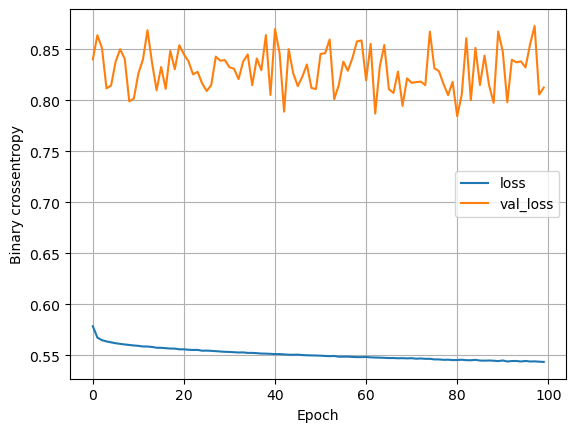

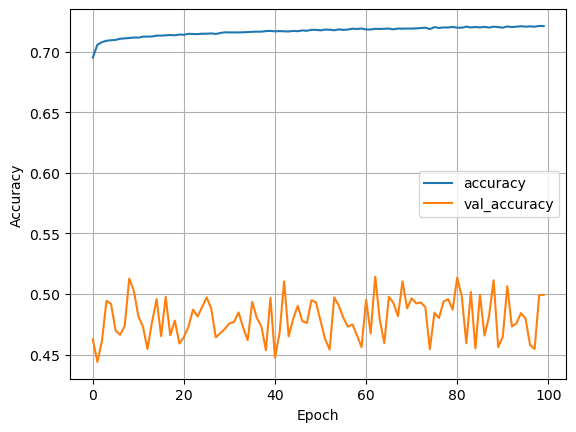

7980/7980 ━━━━━━━━━━━━━━━━━━━━ 7s 823us/step - accuracy: 0.8178 - loss: 0.4248
64 nodes, 0.1 drop prob, 0.0001 learning rate, 64 batch_size


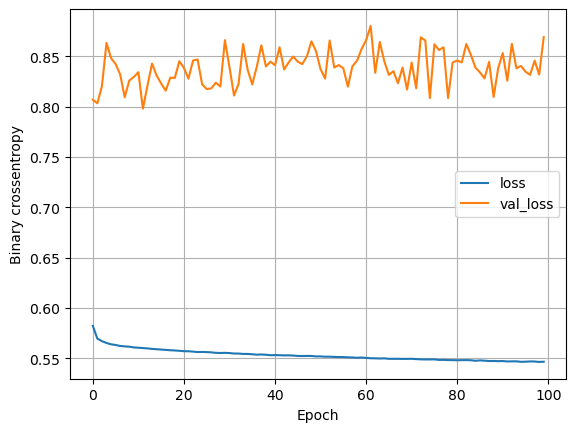

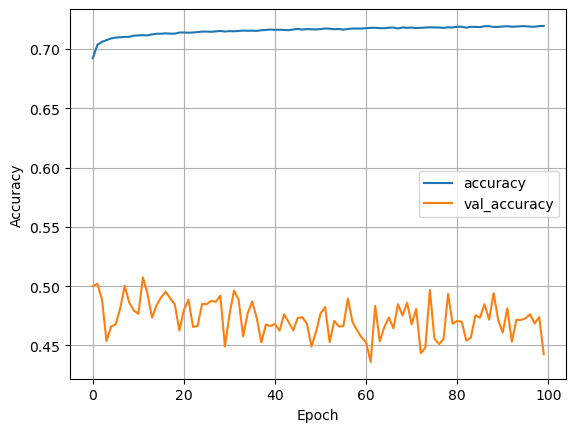

7980/7980 ━━━━━━━━━━━━━━━━━━━━ 6s 808us/step - accuracy: 0.8338 - loss: 0.4099
64 nodes, 0.1 drop prob, 0.0001 learning rate, 128 batch_size


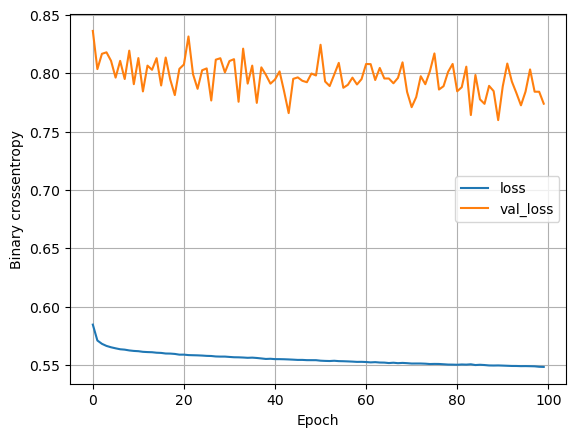

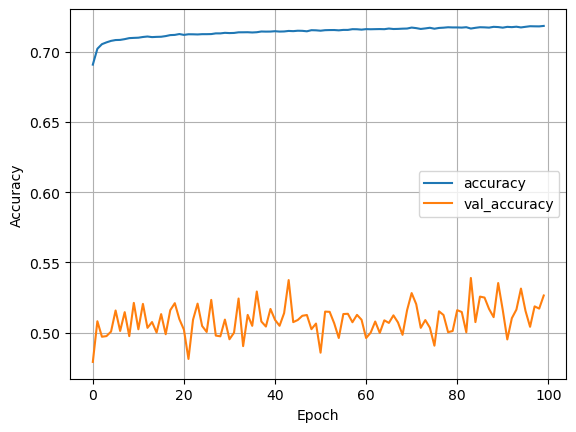

7980/7980 ━━━━━━━━━━━━━━━━━━━━ 7s 904us/step - accuracy: 0.8031 - loss: 0.4495
64 nodes, 0.1 drop prob, 0.001 learning rate, 32 batch_size


KeyboardInterrupt: 

In [93]:
least_val_loss = float('inf')
leat_val_model = None
epochs=100
for n_nodes in [64,128,256]:
    for drop_prob in [0.1,0.5]: 
        for lr in [0.0001, 0.001, 0.01]: 
            for batch_size in [32, 64, 128]:
                print(f'{n_nodes} nodes, {drop_prob} drop prob, {lr} learning rate, {batch_size} batch_size')
                model, history = train_model(x_train, y_train, n_nodes, drop_prob, lr, batch_size, epochs)
                plot_loss(history)
                plot_accuracy(history)
                val_loss = model.evaluate(x_valid, y_valid)
                if val_loss[0] < least_val_loss: 
                    least_val_loss = val_loss[0]
                    least_val_model = model